<IPython.core.display.Javascript object>


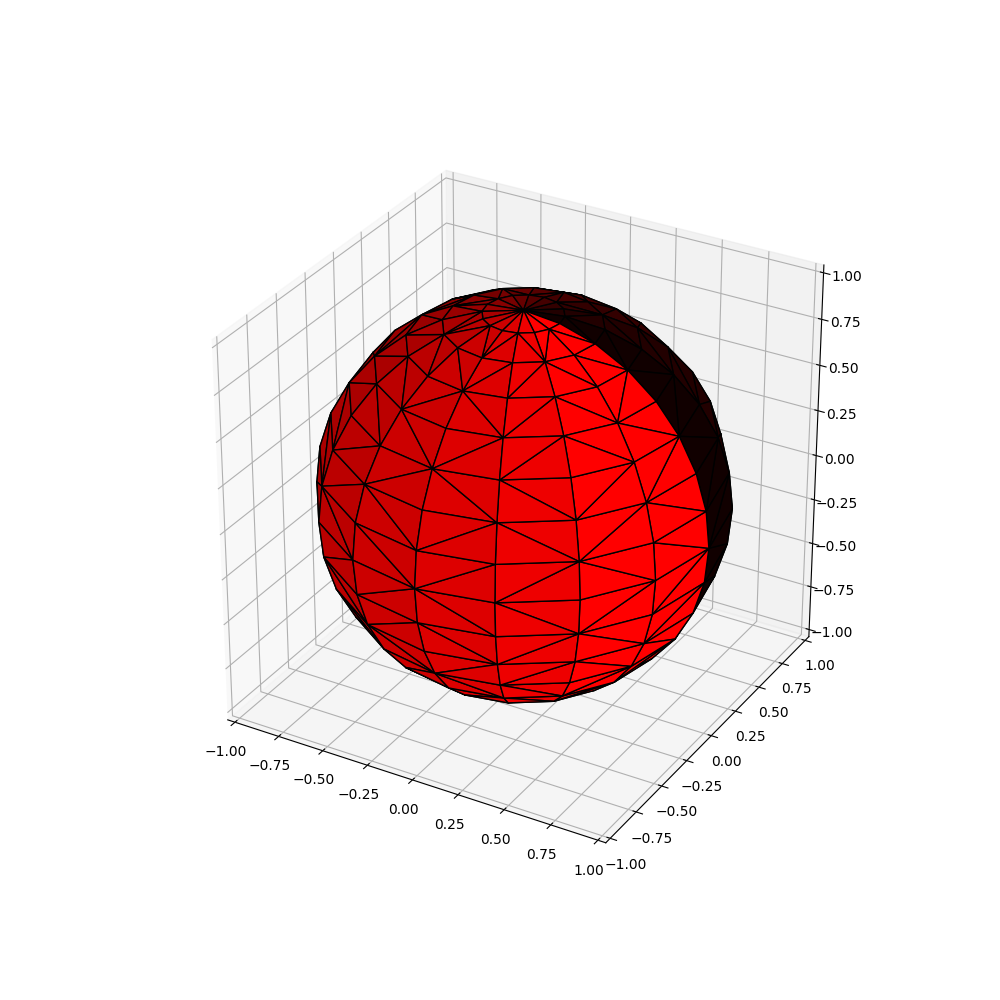

In [7]:
import numpy as np
import scipy.sparse.linalg


bw = 8
npix = 2*bw*(2*bw-1)+1
L = scipy.sparse.load_npz('matrices/stiffness_matrix_{}.npz'.format(bw))
B = scipy.sparse.load_npz('matrices/mass_matrix_{}.npz'.format(bw))
reordering_mask = np.load("15_reordering_masks/reordering_mask_{}.npy".format(bw))

L = L[reordering_mask]
B = B[reordering_mask]
L = L[:, reordering_mask]
B = B[:, reordering_mask]


eig_values, eig_vectors = scipy.linalg.eigh(L.toarray(), B.toarray())
eig_values_normalized = eig_values/np.max(eig_values)
eig_vectors_INV = np.linalg.inv(eig_vectors)


def ffilter(x):
    return eig_vectors@np.diag(np.exp(-eig_values_normalized))@eig_vectors_INV@x


def makesignal(x):
    return x.flatten()[2*bw-1:]


def maketable(x):
    x0 = x[0]
    x = np.concatenate([x0*np.ones(2*bw-1), x])
    x.resize((2*bw, 2*bw))
    return x

# Define the convolution
def phi(x):  # OK
    x = makesignal(x)
    x = ffilter(x)
    return maketable(x)

def create_coords(bw):
    alpha = np.arange(2 * bw) * np.pi / bw
    beta = np.arange(2 * bw) * np.pi / (2. * bw)
    theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
    ct = np.cos(theta).flatten()
    st = np.sin(theta).flatten()
    cp = np.cos(phi).flatten()
    sp = np.sin(phi).flatten()
    x = st * cp
    y = st * sp
    z = ct
    coords = np.vstack([x, y, z]).T
    coords = np.asarray(coords, dtype=np.float32)
    coords = coords[2*bw-1:]
    return coords

def rot(x, angle):
    # rotate the signal around the Z axis
    n = round(x.shape[1] * angle / 360)
    return np.concatenate([x[:, n:], x[:, :n]], axis=1)

# Create random input
alpha = np.arange(2 * bw) * np.pi / bw
beta = np.arange(2 * bw) * np.pi / (2. * bw)
_, x = np.meshgrid(*(beta, alpha),indexing='ij')
x[0] = x[0,0]

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
%matplotlib notebook
from scipy.spatial import ConvexHull

def plotsphere(fig, signal, coords, tri):
    m = np.min(signal)
    signal = signal-m
    ax = fig.add_subplot(1,1,1, projection='3d')
    M = np.max(signal)
    for simplex in tri.simplices:
        triangle = a3.art3d.Poly3DCollection([coords[simplex]])
        triangle.set_color(colors.rgb2hex([np.max(signal[simplex])/M, 0,0]))
        triangle.set_edgecolor('k')
        ax.add_collection3d(triangle)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    
def subplotsphere(fig, signal, coords, tri, j):
    m = np.min(signal)
    signal = signal-m
    ax = fig.add_subplot(2,2,j, projection='3d')
    M = np.max(signal)
    for simplex in tri.simplices:
        triangle = a3.art3d.Poly3DCollection([coords[simplex]])
        triangle.set_color(colors.rgb2hex([np.max(signal[simplex])/M, 0,0]))
        triangle.set_edgecolor('k')
        ax.add_collection3d(triangle)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)

    
fig = plt.figure(figsize=(10,10))
coords = create_coords(bw)
tri = ConvexHull(coords)  



plotsphere(fig, makesignal(x), coords, tri)

In [8]:
y = phi(x)
y1 = rot(phi(x), angle=45)
y2 = phi(rot(x, angle=45))

relative_error = np.std(y1 - y2) / np.std(y)

print('relative error = {}'.format(relative_error))

relative error = 0.10984469248501985


<IPython.core.display.Javascript object>


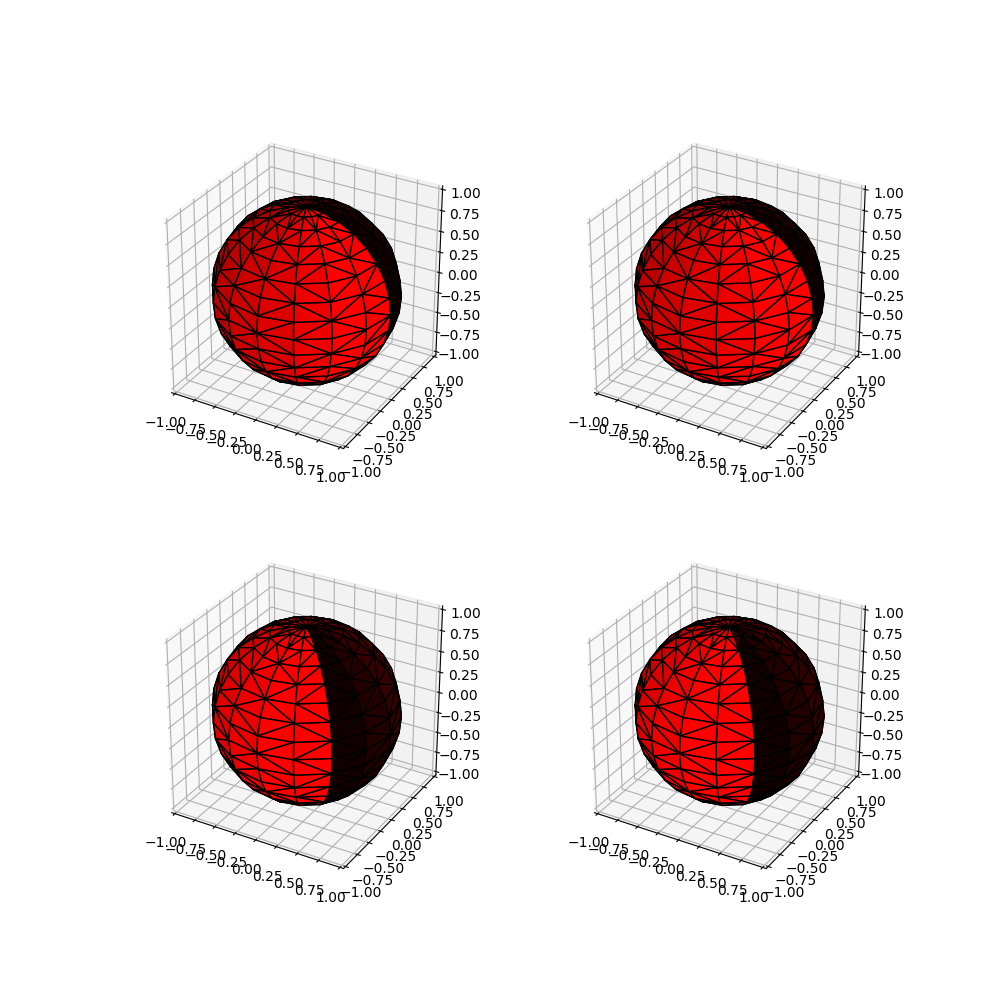

In [9]:
fig = plt.figure(figsize=(10,10))

subplotsphere(fig, makesignal(x), coords, tri, 1)
subplotsphere(fig, makesignal(y), coords, tri, 2)
subplotsphere(fig, makesignal(y1), coords, tri, 3)
subplotsphere(fig, makesignal(y2), coords, tri, 4)
plt.savefig('img/equivariance_error_FEM')

In [11]:
from pygsp.graphs import Graph

class FullSphereEquiangular(Graph):
    """Modified from the class implemented by Droxef
    https://github.com/Droxef/PDMdeepsphere/
    """
    sigmas = {4:0.5,
              8:0.3,
              16: 0.1, 
              32: 0.03,
              64: 0.01}
    
    def __init__(self, bw=64):
       
        self.bw = bw

        ## sampling and coordinates calculation
        alpha = np.arange(2 * bw) * np.pi / bw
        beta = np.arange(2 * bw) * np.pi / (2. * bw)
      
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        coords = coords[2*bw-1:]
        
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        W = np.exp(-distances_squared/self.sigmas[bw])
        W = W-np.diag(np.diag(W))
        super(FullSphereEquiangular, self).__init__(W=W, coords=coords)

In [12]:
# Define the convolution
L = scipy.linalg.expm(-FullSphereEquiangular(bw).L)
def phi(x):  # OK
    x = makesignal(x)
    x = L@x
    return maketable(x)

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [13]:

# Create input
alpha = np.arange(2 * bw) * np.pi / bw
beta = np.arange(2 * bw) * np.pi / (2. * bw)
_, x = np.meshgrid(*(beta, alpha),indexing='ij')
x[0] = x[0,0]

y = phi(x)
y1 = rot(phi(x), angle=45)
y2 = phi(rot(x, angle=45))

relative_error = np.std(y1 - y2) / np.std(y)

print('relative error = {}'.format(relative_error))

relative error = 4.219171298022432e-08


<IPython.core.display.Javascript object>


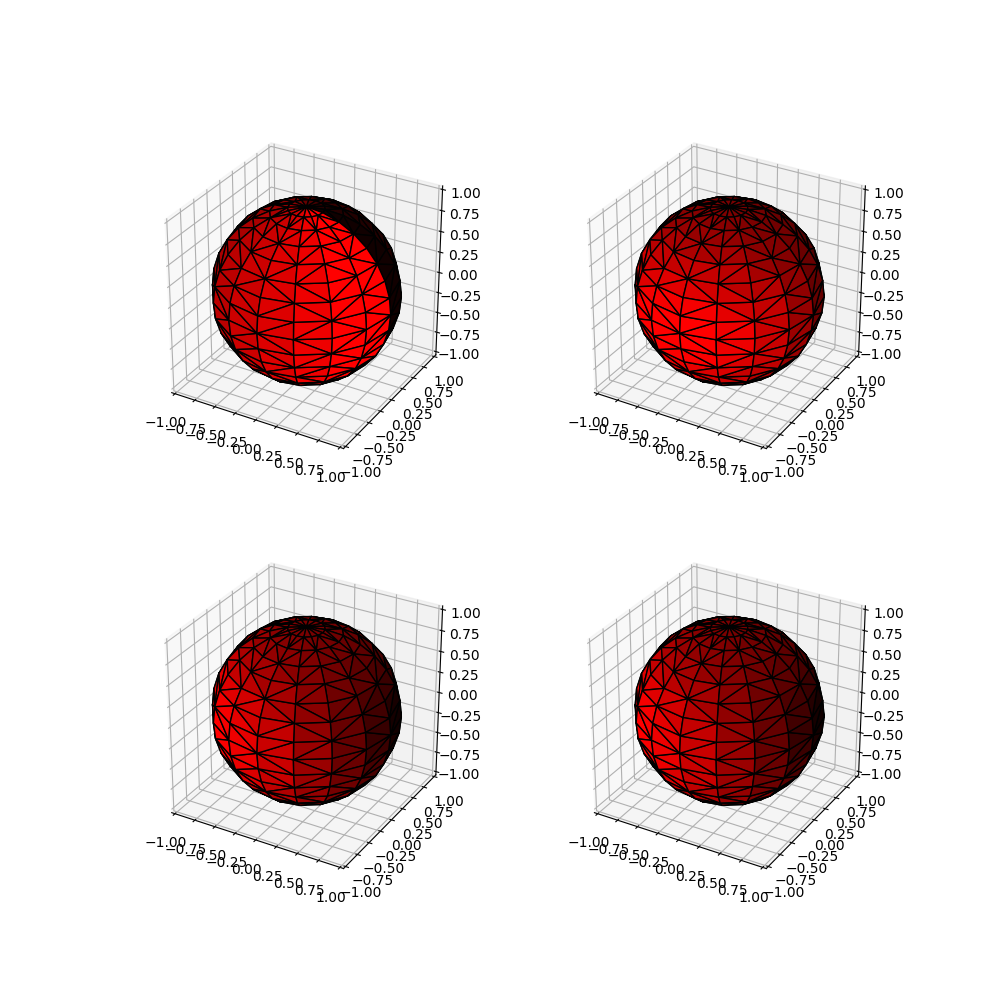

In [14]:
fig = plt.figure(figsize=(10,10))

subplotsphere(fig, makesignal(x), coords, tri, 1)
subplotsphere(fig, makesignal(y), coords, tri, 2)
subplotsphere(fig, makesignal(y1), coords, tri, 3)
subplotsphere(fig, makesignal(y2), coords, tri, 4)
plt.savefig('img/equivariance_error_GRAPH')